In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import mlflow

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from model import *
from utils import *
from train import *

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("tool_wear_detection")

# MinIO 설정
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://localhost:9000'  # MinIO port
os.environ['AWS_ACCESS_KEY_ID'] = 'minio'  # MINIO_ROOT_USER
os.environ['AWS_SECRET_ACCESS_KEY'] = 'miniostorage'  # MINIO_ROOT_PASSWORD

# load data

In [3]:
dir_path = '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms'

train_tnum = 'T1'
test_tnum = 'T5'

Tx_train = preprocess_data(train_tnum, dir_path)
Tx_test = preprocess_data(test_tnum, dir_path)

train_slice = Tx_train[Tx_train['Expt'].isin([1, 2])].drop(columns=['Expt']).to_numpy()  # Expt 1, 2만 사용
train_slice, val_slice = stratified_sampling(train_slice, 0.15)

scaler = StandardScaler()
train_slice_scaled = scaler.fit_transform(train_slice)
val_slice_scaled = scaler.transform(val_slice)
test_scaled = scaler.transform(Tx_test.drop(columns=['Expt']).to_numpy())

# Convert data to PyTorch tensors
X_train = torch.tensor(train_slice_scaled, dtype=torch.float32).cuda()
X_val = torch.tensor(val_slice_scaled, dtype=torch.float32).cuda()
X_test = torch.tensor(test_scaled, dtype=torch.float32).cuda()

# model train

In [4]:
with mlflow.start_run(description="Autoencoder", run_name="auto_encoder"):
	# DataLoader 설정
	mlflow.autolog()
	mlflow.log_params({
		"batch_size": 128,
		"epochs": 30
	})
	mlflow.set_tag("model", "AutoEncoder")
	mlflow.log_params({
		"train_dirs": os.path.join(dir_path, train_tnum),
		"test_dirs": os.path.join(dir_path, test_tnum)
	})
	
	train_loader = DataLoader(TensorDataset(X_train), batch_size=128, shuffle=True)
	val_loader = DataLoader(TensorDataset(X_val), batch_size=128, shuffle=False)

	# Autoencoder 모델 초기화
	input_dim = X_train.shape[1]
	model = Autoencoder(input_dim).cuda()
	model.preprocessor = scaler

	# Loss 함수와 Optimizer 설정
	criterion = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.01)

	# Train the model
	trained_model, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=30)

	model_path = "model.pkl"
	preprocessor_path = "preprocessor.pkl"
	model.save(model_path, preprocessor_path)
 
	wrapped_model = AutoEncoderWrapper(model)
	mlflow.pyfunc.log_model(
		"model",
		python_model=wrapped_model,
		artifacts={"model": model_path, "preprocessor": preprocessor_path},
	)
 
	th = 0.5
	score_test, anomaly_indices, metrics = evaluate_model(trained_model, X_test, th, dir_path, test_tnum)
	
	mlflow.log_metric("accuracy", metrics["accuracy"])
	mlflow.log_metric("precision", metrics["precision"])
	mlflow.log_metric("recall", metrics["recall"])
	mlflow.log_metric("f1_score", metrics["f1"])

2025/01/08 13:30:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Epoch [1/30], Loss: 0.0446, Val Loss: 0.0173 (Best model)
Epoch [2/30], Loss: 0.0258, Val Loss: 0.0073 (Best model)
Epoch [3/30], Loss: 0.0237, Val Loss: 0.0190
Epoch [4/30], Loss: 0.0218, Val Loss: 0.0429
Epoch [5/30], Loss: 0.0204, Val Loss: 0.0145
Epoch [6/30], Loss: 0.0190, Val Loss: 0.0067 (Best model)
Epoch [7/30], Loss: 0.0180, Val Loss: 0.0074
Epoch [8/30], Loss: 0.0177, Val Loss: 0.0055 (Best model)
Epoch [9/30], Loss: 0.0174, Val Loss: 0.0069
Epoch [10/30], Loss: 0.0158, Val Loss: 0.0056
Epoch [11/30], Loss: 0.0159, Val Loss: 0.0103
Epoch [12/30], Loss: 0.0158, Val Loss: 0.0092
Epoch [13/30], Loss: 0.0158, Val Loss: 0.0058
Epoch [14/30], Loss: 0.0147, Val Loss: 0.0031 (Best model)
Epoch [15/30], Loss: 0.0150, Val Loss: 0.0041
Epoch [16/30], Loss: 0.0144, Val Loss: 0.0032
Epoch [17/30], Loss: 0.0146, Val Loss: 0.0079
Epoch [18/30], Loss: 0.0145, Val Loss: 0.0049
Epoch [19/30], Loss: 0.0147, Val Loss: 0.0043
Epoch [20/30], Loss: 0.0147, Val Loss: 0.0038
Epoch [21/30], Loss: 0.0

2025/01/08 13:31:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpre9n95vc/model, flavor: python_function). Fall back to return ['cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2025/01/08 13:31:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run auto_encoder at: http://localhost:8080/#/experiments/5/runs/29c5abf5ce7b4709aac0bde305eb5abe
🧪 View experiment at: http://localhost:8080/#/experiments/5



Results:
Training -> Validation: Best Val Loss = 0.0031


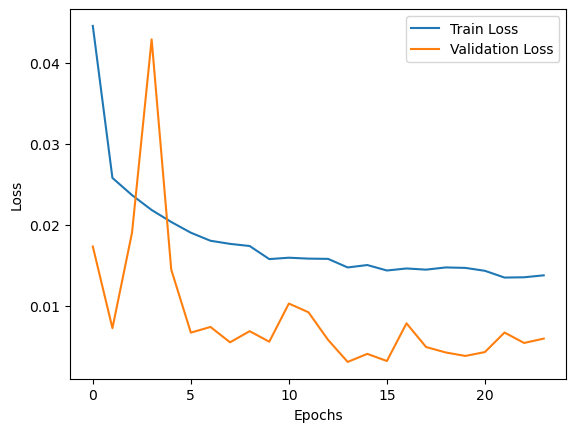

In [5]:
print("\nResults:")
print(f"Training -> Validation: Best Val Loss = {min(val_loss):.4f}")

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

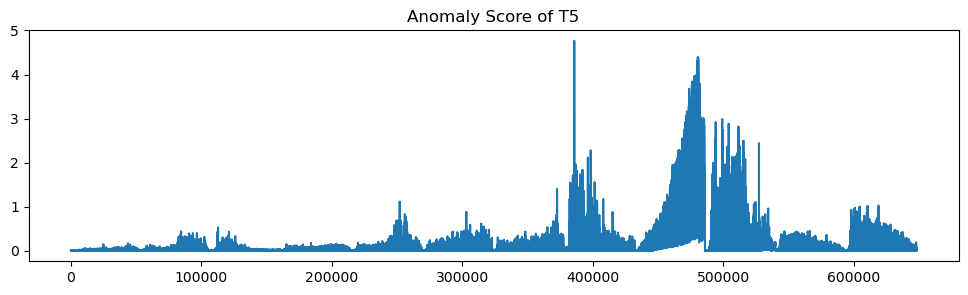

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(score_test)
plt.title(f'Anomaly Score of {test_tnum}')
plt.show()

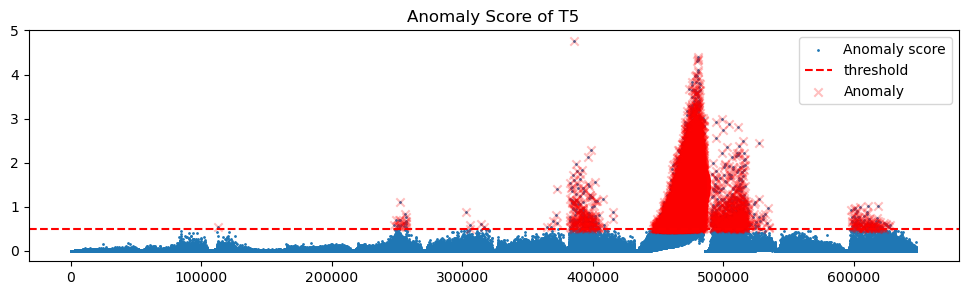

In [7]:
plt.figure(figsize=(12, 3))
plt.scatter(range(len(score_test)), score_test, s=1, label='Anomaly score')
plt.axhline(y=th, c='red', linestyle='--', label='threshold')
plt.scatter(anomaly_indices, score_test[anomaly_indices], marker='x', c='red', alpha=0.25, label='Anomaly')
plt.title(f'Anomaly Score of T5')
plt.legend()
plt.show()

In [8]:
# 결과 출력
print(f"Accuracy: {metrics['accuracy']:.2f}")
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1-Score: {metrics['f1']:.2f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

Accuracy: 0.94
Precision: 0.79
Recall: 1.00
F1-Score: 0.88
Confusion Matrix:
[[456083  40043]
 [     0 151874]]
